# Notebook : 02_fruits_pipeline_simulation.ipynb - VERSION SIMULATION S3

# ============================================================================
# 📋 CELLULE 1 : IMPORTS ET CONFIGURATION
# ============================================================================

In [60]:
import os
import sys
import warnings

# === SUPPRESSION RADICALE DE TOUS LES WARNINGS ===
warnings.filterwarnings('ignore')

# Configuration AVANT tous les imports
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONWARNINGS'] = 'ignore'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

# Redirection temporaire de stderr pour masquer les messages TensorFlow/CUDA
original_stderr = sys.stderr
if os.name != 'nt':  # Linux/Mac
    sys.stderr = open('/dev/null', 'w')
else:  # Windows
    sys.stderr = open('nul', 'w')

try:
    from pyspark.sql import SparkSession
    from pyspark.sql import functions as F
    from pyspark.ml.feature import PCA
    import matplotlib.pyplot as plt
    import numpy as np
    from tensorflow.python.client import device_lib
    from IPython.display import Image, display
    import shutil
    
finally:
    # Restauration de stderr après les imports
    sys.stderr.close() 
    sys.stderr = original_stderr

# Configuration matplotlib silencieuse
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib
matplotlib.use('Agg')  # Mode non-interactif

# Préservation de la fonction sum() native Python
python_sum = __builtins__['sum'] if isinstance(__builtins__, dict) else __builtins__.sum

# Ajout du répertoire src au PYTHONPATH pour les imports
sys.path.append('../src')

# Imports des modules personnalisés
from preprocessing import load_images_from_directory, extract_features_mobilenet
from pca_reduction import convert_array_to_vector, get_optimal_pca_k, plot_variance_explained, apply_pca_on_features, plot_variance_curve
from utils import export_dataframe_if_needed, setup_project_directories, clean_gpu_cache

# Import du module EMR Simulation optimisé
from emr_simulation import get_spark_session, get_s3_client, EMRSimulation, create_bucket_if_not_exists, get_optimal_config_for_hardware

clean_gpu_cache()

print("✅ Imports réalisés avec succès")

# Test détection hardware automatique
print("\n🔍 Détection automatique du hardware...")
hw_config = get_optimal_config_for_hardware()
print(f"🎯 Configuration recommandée : {hw_config['memory_recommendation']}")

# Test des imports critiques pour la simulation
try:
    import boto3
    print("✅ boto3 OK")
except ImportError:
    print("⚠️ boto3 manquant - pip install boto3")

# Test awslocal comme outil CLI (pas module Python)
import subprocess
try:
    result = subprocess.run(['which', 'awslocal'], capture_output=True, text=True)
    if result.returncode == 0:
        print("✅ awslocal CLI OK")
    else:
        print("⚠️ awslocal CLI manquant - pip install awscli-local")
except Exception:
    print("⚠️ awslocal CLI non testé")

try:
    import localstack
    print("✅ localstack module OK")
except ImportError:
    print("⚠️ localstack manquant - pip install localstack")

print("✅ Module EMR Simulation optimisé importé et testé")

[INFO] Mémoire GPU nettoyée avec succès.
✅ Imports réalisés avec succès

🔍 Détection automatique du hardware...
🚀 GPU détecté: /physical_device:GPU:0
💾 RAM détectée: 31.3 GB
🎯 Configuration recommandée : 6g/4g
✅ boto3 OK
✅ awslocal CLI OK
✅ localstack module OK
✅ Module EMR Simulation optimisé importé et testé


# ============================================================================
# 📋 CELLULE 2 : INITIALISATION SPARK MODE SIMULATION
# ============================================================================

In [2]:
print("🚀 Initialisation en mode SIMULATION (LocalStack S3)")

🚀 Initialisation en mode SIMULATION (LocalStack S3)


## 2.1 - CONFIGURATION DU MODE - MODIFIABLE ICI

In [3]:
MODE = "simulation"  # Options: "local", "simulation", "production"

print(f"🔧 Mode sélectionné : {MODE}")

🔧 Mode sélectionné : simulation


## 2.2 - Création session Spark avec auto-optimisation
- Détection automatique GPU et configuration intelligente

In [4]:
enable_gpu = hw_config["gpu_available"] and MODE == "local"

spark = get_spark_session(
    mode=MODE, 
    app_name="FruitsPipelineSimulation",
    enable_gpu=enable_gpu  # 🔴 Auto-détection GPU
)

🔧 EMRSimulation initialisé en mode: simulation


your 131072x1 screen size is bogus. expect trouble
25/07/25 11:30:22 WARN Utils: Your hostname, PC-ARNAUD resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/07/25 11:30:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/nono66/P11/2-python/venv_p11/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/nono66/.ivy2/cache
The jars for the packages stored in: /home/nono66/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-185fe18a-cc8c-4695-8cff-ecda96e8da46;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.696 in central
downloading https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.4/hadoop-aws-3.3.4.jar ...
	[SUCCESSFUL ] org.apache.hadoop#hadoop-aws;3.3.4!hadoop-aws.jar (94ms)
downloading https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.12.696/aws-java-sdk-bundle-1.12.696.jar ...
	[SUCCESSFUL ] com.amazonaws#aws-java-sdk-bundle;1.12.696!aws-java-sdk-bundle.jar (3353ms)
downloading https://repo1.maven.org/maven2/org/wildfly/openssl/wildfly-openssl/1.0.7.Fi

✅ Session Spark créée - Mode: simulation - Version: 3.4.1
📊 Config mémoire: 3g executor / 2g driver
🎯 Cores disponibles: 16


## 2.3 - Configuration du logging

In [5]:
spark.sparkContext.setLogLevel("ERROR")

## 2.4 - onfiguration EMR Simulation avec GPU

In [6]:
emr_config = EMRSimulation(mode=MODE, enable_gpu=enable_gpu)

print(f"🚀 Session Spark créée : {spark.version}")
print(f"📊 Nombre de cœurs disponibles : {spark.sparkContext.defaultParallelism}")
print(f"🗂️ Stockage configuré : {emr_config.get_storage_path()}")

🔧 EMRSimulation initialisé en mode: simulation
🚀 Session Spark créée : 3.4.1
📊 Nombre de cœurs disponibles : 16
🗂️ Stockage configuré : s3a://fruits-p11-simulation


## 2.5 - Affichage de la config mémoire appliquée

In [7]:
memory_config = emr_config.get_memory_config()
print(f"💾 Config mémoire : {memory_config['spark.executor.memory']} executor / {memory_config['spark.driver.memory']} driver")

💾 Config mémoire : 3g executor / 2g driver


# ============================================================================
# 📋 CELLULE 3 : CONFIGURATION DES CHEMINS ET RÉPERTOIRES
# ============================================================================

In [8]:
print("📁 Configuration des chemins selon le mode...")

📁 Configuration des chemins selon le mode...


## 3.1 - Chemin des données d'entrée (toujours local)

In [9]:
DATA_PATH = "../data/fruits-360/Test"

## 3.2 - Chemins de sortie selon le mode

In [10]:
if MODE == "local":
    OUTPUTS_PATH = "../outputs"
    CACHE_PATH = "../outputs/cache"
else:
    # Modes simulation et production : utilisation S3
    OUTPUTS_PATH = emr_config.get_storage_path()
    CACHE_PATH = emr_config.get_storage_path("cache")

print(f"📁 Chemin des données : {DATA_PATH}")
print(f"📁 Chemin de sortie : {OUTPUTS_PATH}")
print(f"📁 Chemin cache : {CACHE_PATH}")

📁 Chemin des données : ../data/fruits-360/Test
📁 Chemin de sortie : s3a://fruits-p11-simulation
📁 Chemin cache : s3a://fruits-p11-simulation/cache


## 3.3 - Création de l'arborescence pour le mode local

In [11]:
if MODE == "local":
    directories = setup_project_directories(base_path="../")
    print("📁 Répertoires locaux configurés")

## 3.4 - Vérification de l'existence des données

In [12]:
if not os.path.exists(DATA_PATH):
    print(f"❌ ERREUR : Le répertoire {DATA_PATH} n'existe pas !")
    print("💡 Assure-toi d'avoir téléchargé et extrait le dataset Fruits-360")
else:
    total_images = python_sum([len(files) for r, d, files in os.walk(DATA_PATH) if files])
    print(f"📸 Nombre total d'images détectées : {total_images}")

📸 Nombre total d'images détectées : 22688


# ============================================================================
# 📋 CELLULE 4 : CONFIGURATION BUCKET S3 (AVEC TESTS AVANCÉS)
# ============================================================================

In [13]:
print("🪣 Configuration et test avancé du bucket S3...")

🪣 Configuration et test avancé du bucket S3...


## 4.1 - Configuration S3 selon le mode

In [14]:
if MODE in ["simulation", "production"]:
    # Nom du bucket selon le mode
    bucket_name = "fruits-p11-simulation" if MODE == "simulation" else "fruits-p11-production"
    
    # Test de connectivité S3 via module optimisé
    print(f"🔍 Test connectivité S3 pour mode {MODE}...")
    emr_test = EMRSimulation(mode=MODE)
    s3_connection_ok = emr_test.test_s3_connection()
    
    if s3_connection_ok:
        print("✅ Connexion S3 établie")
        
        # Création/vérification du bucket
        success = create_bucket_if_not_exists(mode=MODE, bucket_name=bucket_name)
        
        if success:
            print(f"✅ Bucket {bucket_name} prêt")
            
            # Test avancé lecture/écriture avec métadonnées
            try:
                s3_client = get_s3_client(mode=MODE)
                
                # Test avec métadonnées enrichies
                test_content = f"Test pipeline {MODE} optimisé - " + str(np.random.randint(1000, 9999))
                test_key = "test/connectivity_test_advanced.txt"
                
                # Écriture avec métadonnées
                s3_client.put_object(
                    Bucket=bucket_name,
                    Key=test_key,
                    Body=test_content,
                    Metadata={
                        'pipeline-version': '2.0',
                        'test-type': 'connectivity',
                        'gpu-enabled': str(enable_gpu)
                    }
                )
                
                # Test lecture
                response = s3_client.get_object(Bucket=bucket_name, Key=test_key)
                read_content = response['Body'].read().decode('utf-8')
                
                if test_content == read_content:
                    print("✅ Test lecture/écriture S3 avancé OK")
                    print(f"📊 Métadonnées : {response.get('Metadata', {})}")
                else:
                    print("⚠️ Problème cohérence lecture/écriture S3")
                    
            except Exception as e:
                print(f"❌ Erreur test S3 avancé : {e}")
                print("💡 Vérifiez que LocalStack est démarré : docker ps")
        else:
            print(f"❌ Impossible de configurer le bucket {bucket_name}")
            print("💡 Le pipeline continuera mais les sauvegardes pourraient échouer")
    else:
        print("❌ Connexion S3 échouée")
        print("💡 Vérifiez LocalStack (simulation) ou credentials AWS (production)")

else:
    print("📁 Mode local : pas de configuration S3 nécessaire")

🔍 Test connectivité S3 pour mode simulation...
🔧 EMRSimulation initialisé en mode: simulation
🔧 EMRSimulation initialisé en mode: simulation
✅ Client S3 créé - Mode: simulation
✅ Connexion S3 établie
🔧 EMRSimulation initialisé en mode: simulation
✅ Client S3 créé - Mode: simulation
✅ Bucket fruits-p11-simulation existe déjà
✅ Bucket fruits-p11-simulation prêt
🔧 EMRSimulation initialisé en mode: simulation
✅ Client S3 créé - Mode: simulation
✅ Test lecture/écriture S3 avancé OK
📊 Métadonnées : {'pipeline-version': '2.0', 'test-type': 'connectivity', 'gpu-enabled': 'False'}


# ============================================================================
# 📋 CELLULE 5 : CHARGEMENT DES DONNÉES
# ============================================================================

In [15]:
print("\n🔄 Étape 1/5 : Chargement des images depuis le répertoire...")


🔄 Étape 1/5 : Chargement des images depuis le répertoire...


## 5.1 - Configuration du cache selon le mode

In [16]:
if MODE == "local":
    cache_path_images = f"{CACHE_PATH}/images_paths.parquet"
else:
    cache_path_images = emr_config.get_storage_path("cache/images_paths.parquet")

print(f"💾 Cache images : {cache_path_images}")

df_images = load_images_from_directory(
    spark=spark, 
    data_path=DATA_PATH,
    sample_size=500,  # Limitation pour les tests - à augmenter en production
    cache_path=cache_path_images,
    force_retrain=False
)

print("✅ Chargement terminé")
print("📊 Aperçu des données :")
df_images.show(5, truncate=False)
print(f"📈 Nombre total d'images chargées : {df_images.count()}")

💾 Cache images : s3a://fruits-p11-simulation/cache/images_paths.parquet
🔍 Scan du répertoire : ../data/fruits-360/Test
   📂 Traitement de la classe : Tomato Maroon
      → 127 images trouvées
   📂 Traitement de la classe : Nut Pecan
      → 178 images trouvées
   📂 Traitement de la classe : Grape White 3
      → 164 images trouvées
   📂 Traitement de la classe : Strawberry
🎯 Limite de 500 images atteinte
      → 31 images trouvées
📊 Total : 500 images, 4 classes


✅ Chargement terminé
📊 Aperçu des données :
+--------------------------------------------------+-------------+
|path                                              |label        |
+--------------------------------------------------+-------------+
|../data/fruits-360/Test/Tomato Maroon/252_100.jpg |Tomato Maroon|
|../data/fruits-360/Test/Tomato Maroon/25_100.jpg  |Tomato Maroon|
|../data/fruits-360/Test/Tomato Maroon/r_27_100.jpg|Tomato Maroon|
|../data/fruits-360/Test/Tomato Maroon/r_46_100.jpg|Tomato Maroon|
|../data/fruits-360/Test/Tomato Maroon/r_37_100.jpg|Tomato Maroon|
+--------------------------------------------------+-------------+
only showing top 5 rows

📈 Nombre total d'images chargées : 500


# ============================================================================
# 📋 CELLULE 6 : EXTRACTION DES FEATURES AVEC MOBILENETV2
# ============================================================================

In [17]:
print("\n🔄 Étape 2/5 : Extraction des features avec MobileNetV2...")
print("⚠️  Cette étape peut prendre plusieurs minutes selon le nombre d'images")


🔄 Étape 2/5 : Extraction des features avec MobileNetV2...
⚠️  Cette étape peut prendre plusieurs minutes selon le nombre d'images


## 6.1 - Configuration du cache selon le mode 

In [ ]:
if MODE == "local":
    cache_path_features = f"{CACHE_PATH}/features_mobilenet_gpu.parquet"
else:
    cache_path_features = emr_config.get_storage_path("cache/features_mobilenet_simulation.parquet")

print(f"💾 Cache features : {cache_path_features}")

# Batch size adaptatif selon GPU et mode
if enable_gpu and MODE == "local":
    batch_size = 32  # GTX 1060 6GB optimisé
    print("🚀 Mode GPU activé : batch_size=32")
elif MODE == "production":
    batch_size = 64  # AWS instances plus puissantes
    print("☁️ Mode production : batch_size=64")
else:
    batch_size = 16  # Simulation/CPU : plus conservateur
    print("💻 Mode CPU/simulation : batch_size=16")

df_features = extract_features_mobilenet(
    spark=spark,
    df=df_images,
    cache_path=cache_path_features,
    force_retrain=False,
    batch_size=batch_size  # 🔴 Batch size adaptatif
)

print("✅ Extraction des features terminée")
print("📊 Vérification des dimensions des features :")

💾 Cache features : s3a://fruits-p11-simulation/cache/features_mobilenet_simulation.parquet
💻 Mode CPU/simulation : batch_size=16
🤖 Initialisation MobileNetV2 sur GPU...
🔄 Fallback sur CPU
📐 Dimensions : (None, 1280)
🎯 Device : /CPU:0
📡 Broadcast du modèle...
🔄 Extraction features GPU...
✅ 500 features extraites
⏱️  Temps : 0.34s
🚀 Vitesse : 1466.60 img/s


📐 Dimension : 1280


✅ Extraction des features terminée
📊 Vérification des dimensions des features :


## 6.2 - Inspection d'un échantillon de features

In [19]:
sample_features = df_features.select("features").first()["features"]
print(f"🎯 Dimension des vecteurs de caractéristiques : {len(sample_features)}")
print(f"🎯 Type des données : {type(sample_features)}")
print(f"🎯 Exemple de valeurs : {sample_features[:10]}...")

🎯 Dimension des vecteurs de caractéristiques : 1280
🎯 Type des données : <class 'list'>
🎯 Exemple de valeurs : [0.023533353582024574, 0.27063125371932983, 0.0, 0.06948061287403107, 0.018585652112960815, 1.067103385925293, 1.0914256572723389, 0.31432127952575684, 0.19152486324310303, 0.0]...


# ============================================================================
# 📋 CELLULE 7 : CONVERSION AU FORMAT SPARK ML
# ============================================================================

In [20]:
print("\n🔄 Étape 3/5 : Conversion des données au format Spark ML...")


🔄 Étape 3/5 : Conversion des données au format Spark ML...


## 7.1 - Conversion nécessaire pour PCA via fonction externalisée

In [21]:
df_features_converted = convert_array_to_vector(df_features, features_col="features")

print("✅ Conversion terminée")
print("📊 Vérification du schéma après conversion :")
df_features_converted.printSchema()

🔄 Conversion des arrays Python vers des vecteurs Spark ML...
✅ Conversion terminée - les features sont maintenant au format VectorUDT
✅ Conversion terminée
📊 Vérification du schéma après conversion :
root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



# ============================================================================
# 📋 CELLULE 8 : CALCUL PCA ULTRA-OPTIMISÉ
# ============================================================================

In [22]:
print("\n🔄 Étape 4/5 : Analyse PCA ultra-optimisée...")


🔄 Étape 4/5 : Analyse PCA ultra-optimisée...


## 8.1 - Cache intelligent du DataFrame features

In [23]:
print("💾 Cache DataFrame en mémoire...")
df_features_converted.cache()
df_features_converted.count()  # Force le cache
print("✅ DataFrame mis en cache")

💾 Cache DataFrame en mémoire...
✅ DataFrame mis en cache


## 8.2 - Configuration cache PCA selon le mode

In [24]:
if MODE == "local":
    cache_path_pca = f"{CACHE_PATH}/pca_variance_analysis_gpu.parquet"
else:
    cache_path_pca = emr_config.get_storage_path("cache/pca_variance_analysis_optimized.parquet")

print(f"💾 Cache PCA optimisé : {cache_path_pca}")

💾 Cache PCA optimisé : s3a://fruits-p11-simulation/cache/pca_variance_analysis_optimized.parquet


## 8.3 - PCA avec réutilisation intelligente des résultats notebook 01

In [25]:
import time
start_time = time.time()

## 8.4 - Vérification cache existant du notebook 01

In [26]:
force_retrain = False
local_cache_pca = "../outputs/cache/pca_variance_analysis.parquet"
k_optimal_precalcule = 56  # Résultat validé notebook 01
local_cache_pca = "../outputs/cache/pca_variance_analysis_gpu.parquet"

print("🔍 Recherche de résultats PCA précédents...")

if os.path.exists(local_cache_pca) and not force_retrain:
    print(f"⚡ TURBO: Réutilisation cache PCA du notebook 01")
    print(f"✅ Cache PCA trouvé : {local_cache_pca}")
    
    try:
        # Chargement des vraies données de variance pour graphiques
        df_variance_cache = spark.read.parquet(local_cache_pca)
        variance_data = [(row.k, row.individual_variance, row.cum_variance) 
                        for row in df_variance_cache.orderBy("k").collect()]
        k_optimal = k_optimal_precalcule
        
        print(f"✅ {len(variance_data)} points de variance chargés depuis cache")
        print(f"🎯 RÉSULTAT RÉUTILISÉ : k_optimal = {k_optimal} composantes")
        
    except Exception as e:
        print(f"⚠️ Erreur chargement cache : {e}")
        print("🔄 Fallback sur calcul optimisé...")
        # Calcul avec paramètres optimisés
        k_optimal, variance_data = get_optimal_pca_k(
            df=df_features_converted,
            spark=spark,
            max_k=70,  # Arrêt précoce (on sait que k=56)
            threshold=0.95,
            force_retrain=False,
            cache_path=cache_path_pca
        )
else:
    print("🔄 Calcul PCA optimisé (cache non trouvé)...")
    # Calcul avec paramètres optimisés
    k_optimal, variance_data = get_optimal_pca_k(
        df=df_features_converted,
        spark=spark,
        max_k=70,  # Réduit de 200 à 70 (sachant que k=56 optimal)
        threshold=0.95,
        force_retrain=False,
        cache_path=cache_path_pca
    )

calc_time = time.time() - start_time
print(f"⚡ Analyse PCA terminée en {calc_time:.1f}s")
print(f"🎯 RÉSULTAT FINAL : k_optimal = {k_optimal} composantes")

🔍 Recherche de résultats PCA précédents...
🔄 Calcul PCA optimisé (cache non trouvé)...
🆕 Pas de cache détecté ou recalcul forcé : calcul des variances cumulées...
📊 Test de k=1 à k=70 composantes principales...
   Calcul PCA pour k=1... Variance cumulée: 0.2656 (26.56%)
   Calcul PCA pour k=2... Variance cumulée: 0.4741 (47.41%)
   Calcul PCA pour k=3... Variance cumulée: 0.5847 (58.47%)
   Calcul PCA pour k=4... Variance cumulée: 0.6639 (66.39%)
   Calcul PCA pour k=5... Variance cumulée: 0.6949 (69.49%)
   Calcul PCA pour k=6... Variance cumulée: 0.7237 (72.37%)
   Calcul PCA pour k=7... Variance cumulée: 0.7455 (74.55%)
   Calcul PCA pour k=8... Variance cumulée: 0.7617 (76.17%)
   Calcul PCA pour k=9... Variance cumulée: 0.7751 (77.51%)
   Calcul PCA pour k=10... Variance cumulée: 0.7868 (78.68%)
   Calcul PCA pour k=11... Variance cumulée: 0.7971 (79.71%)
   Calcul PCA pour k=12... Variance cumulée: 0.8063 (80.63%)
   Calcul PCA pour k=13... Variance cumulée: 0.6063 (60.63%)
   Ca

## 8.5 - Libération intelligente du cache

In [27]:
if calc_time > 30 or MODE in ["simulation", "production"]:
    df_features_converted.unpersist()
    print("🧹 Cache libéré pour optimiser la suite")

🧹 Cache libéré pour optimiser la suite


# ============================================================================
# 📋 CELLULE 9 : GÉNÉRATION DES GRAPHIQUES OPTIMISÉE
# ============================================================================

In [28]:
print("\n📈 Génération du graphique de variance expliquée...")


📈 Génération du graphique de variance expliquée...


## 9.1 - Chemins de graphiques selon le mode

In [61]:
plot_path = "../outputs/pca_variance_plot.png"
final_plot_path = "../outputs/pca_variance_final.png"
analysis_plot_path = "../outputs/pca_variance_analysis.png"

# Pour S3, on génère d'abord en local puis on upload
plots_config = [
    (final_plot_path, "plots/pca_variance_final.png", "variance-curve"),
    (analysis_plot_path, "plots/pca_variance_analysis.png", "variance-analysis")
]

## 9.2 - Génération des graphiques

In [62]:
plot_variance_curve(variance_data, k_optimal, save_path=final_plot_path)
plot_variance_explained(
    variance_data=variance_data,
    threshold=0.95,
    save_path=analysis_plot_path
)

print("✅ Graphiques générés localement")


📈 Génération du graphique de variance expliquée...
💾 Graphique sauvegardé : ../outputs/pca_variance_analysis.png
✅ Graphiques générés localement


## 9.3 - Upload S3 optimisé avec métadonnées

In [64]:
if MODE in ["simulation", "production"]:
    try:
        s3_client = get_s3_client(mode=MODE)
        bucket_name = "fruits-p11-simulation" if MODE == "simulation" else "fruits-p11-production"
        
        # Upload des graphiques avec métadonnées enrichies
        plots_config = [
            (final_plot_path, "plots/pca_variance_final.png", "variance-curve"),
            (analysis_plot_path, "plots/pca_variance_analysis.png", "variance-analysis")
        ]
        
        for local_path, s3_key, plot_type in plots_config:
            if os.path.exists(local_path):
                with open(local_path, 'rb') as f:
                    s3_client.put_object(
                        Bucket=bucket_name,
                        Key=s3_key,
                        Body=f.read(),
                        ContentType='image/png',
                        Metadata={
                            'pipeline-version': '2.0',
                            'plot-type': plot_type,
                            'k-optimal': str(k_optimal),
                            'mode': MODE
                        }
                    )
                print(f"📤 Graphique uploadé : s3://{bucket_name}/{s3_key}")
        
        print("✅ Tous les graphiques uploadés avec métadonnées")
        
    except Exception as e:
        print(f"⚠️ Erreur upload graphiques S3 : {e}")

🔧 EMRSimulation initialisé en mode: simulation
✅ Client S3 créé - Mode: simulation
📤 Graphique uploadé : s3://fruits-p11-simulation/plots/pca_variance_final.png
📤 Graphique uploadé : s3://fruits-p11-simulation/plots/pca_variance_analysis.png
✅ Tous les graphiques uploadés avec métadonnées


# ============================================================================
# 📋 CELLULE 10 : APPLICATION DE L'ACP AVEC K OPTIMAL
# ============================================================================

In [65]:
print(f"\n🔄 Étape 5/5 : Application de l'ACP avec k={k_optimal} composantes...")


🔄 Étape 5/5 : Application de l'ACP avec k=33 composantes...


## 10.1 - Configuration du chemin de sortie selon le mode

In [66]:
if MODE == "local":
    output_path_pca = f"../outputs/features_pca_optimal.parquet"
else:
    output_path_pca = emr_config.get_storage_path("results/features_pca_optimal.parquet")

print(f"💾 Sortie PCA : {output_path_pca}")

df_pca_optimal = apply_pca_on_features(
    spark=spark,
    df=df_features_converted,
    k=k_optimal,
    features_col="features",
    output_path=output_path_pca,
    force_retrain=False
)

print("✅ ACP appliquée avec succès")

💾 Sortie PCA : s3a://fruits-p11-simulation/results/features_pca_optimal.parquet
⚙ Calcul PCA en cours avec k=33 composantes...
📊 Réduction de dimensionnalité appliquée :
   - Dimensions originales : probablement 1280 (MobileNetV2)
   - Dimensions réduites : 33
   - Facteur de réduction : ~38.8x
✅ ACP appliquée avec succès


## 10.2 - Vérification des résultats

In [67]:
print("📊 Vérification des données après ACP :")
df_pca_optimal.printSchema()

📊 Vérification des données après ACP :
root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_pca: vector (nullable = true)



## 10.3 - Inspection des dimensions réduites

In [68]:
sample_pca = df_pca_optimal.select("features_pca").first()["features_pca"]
print(f"🎯 Dimensions après réduction : {sample_pca.size}")
print(f"🎯 Facteur de réduction : {1280 / sample_pca.size:.1f}x")

🎯 Dimensions après réduction : 33
🎯 Facteur de réduction : 38.8x


# ============================================================================
# 📋 CELLULE 11 : SAUVEGARDE ET VALIDATION FINALE
# ============================================================================

In [69]:
print("\n💾 Sauvegarde des résultats finaux...")


💾 Sauvegarde des résultats finaux...


## 11.1 - Sélection des colonnes finales pour la sauvegarde

In [70]:
df_final = df_pca_optimal.select("path", "label", "features_pca")

## 11.2 - Configuration des chemins finaux selon le mode

In [71]:
if MODE == "local":
    final_parquet_path = "../outputs/final_results.parquet"
    final_csv_path = "../outputs/final_results.csv"
else:
    final_parquet_path = emr_config.get_storage_path("final_results.parquet")
    final_csv_path = emr_config.get_storage_path("final_results.csv")

## 11.3 - Sauvegarde au format Parquet (optimal pour Spark)

In [72]:
df_final.write.mode("overwrite").parquet(final_parquet_path)

## 11.4 - Sauvegarde au format CSV pour compatibilité (sans la colonne features_pca)

In [73]:
df_export = df_final.drop("features_pca")
df_export.coalesce(1).write.mode("overwrite").option("header", "true").csv(final_csv_path)

print(f"✅ Résultats sauvegardés :")
print(f"   - Format Parquet : {final_parquet_path}")
print(f"   - Format CSV : {final_csv_path}")

✅ Résultats sauvegardés :
   - Format Parquet : s3a://fruits-p11-simulation/final_results.parquet
   - Format CSV : s3a://fruits-p11-simulation/final_results.csv


# ============================================================================
# 📋 CELLULE 12 : VALIDATION S3 ET RÉSUMÉ FINAL
# ============================================================================

In [74]:
print("\n" + "="*60)
print("📊 RÉSUMÉ DU PIPELINE DE TRAITEMENT OPTIMISÉ")
print("="*60)

print(f"🔧 Mode d'exécution : {MODE}")
print(f"🚀 GPU activé : {enable_gpu}")
print(f"💾 Config mémoire : {memory_config['spark.executor.memory']} / {memory_config['spark.driver.memory']}")
print(f"🗂️  Nombre d'images traitées : {df_final.count()}")
print(f"🏷️  Nombre de classes détectées : {df_final.select('label').distinct().count()}")
print(f"📐 Dimensions originales (MobileNetV2) : 1280")
print(f"📐 Dimensions après ACP : {k_optimal}")
print(f"📊 Variance expliquée : 95%+")
print(f"⚡ Temps calcul PCA : {calc_time:.1f}s")


📊 RÉSUMÉ DU PIPELINE DE TRAITEMENT OPTIMISÉ
🔧 Mode d'exécution : simulation
🚀 GPU activé : False
💾 Config mémoire : 3g / 2g
🗂️  Nombre d'images traitées : 500
🏷️  Nombre de classes détectées : 4
📐 Dimensions originales (MobileNetV2) : 1280
📐 Dimensions après ACP : 33
📊 Variance expliquée : 95%+
⚡ Temps calcul PCA : 154.7s


## 12.1 - Calcul de la taille du fichier final pour le mode local

In [75]:
if MODE == "local" and os.path.exists(final_parquet_path):
    file_size_mb = sum([os.path.getsize(os.path.join(final_parquet_path, f)) 
                       for f in os.listdir(final_parquet_path) 
                       if os.path.isfile(os.path.join(final_parquet_path, f))]) / (1024*1024)
    print(f"💾 Taille du fichier final : {file_size_mb:.1f} MB (Parquet)")

## 12.2 - Validation S3 avancée avec métadonnées

In [76]:
if MODE in ["simulation", "production"]:
    print(f"\n🔍 VALIDATION AVANCÉE S3 - MODE {MODE.upper()}")
    print("="*50)
    
    try:
        s3_client = get_s3_client(mode=MODE)
        bucket_name = "fruits-p11-simulation" if MODE == "simulation" else "fruits-p11-production"
        
        # Liste des objets avec détails
        response = s3_client.list_objects_v2(Bucket=bucket_name)
        
        if 'Contents' in response:
            print(f"📦 Objets dans {bucket_name}:")
            total_size = 0
            objects_by_type = {"results": [], "cache": [], "plots": [], "test": []}
            
            for obj in response['Contents']:
                size_mb = obj['Size'] / (1024*1024)
                total_size += size_mb
                
                # Classification par type
                if obj['Key'].startswith('results/'):
                    objects_by_type["results"].append((obj['Key'], size_mb))
                elif obj['Key'].startswith('cache/'):
                    objects_by_type["cache"].append((obj['Key'], size_mb))
                elif obj['Key'].startswith('plots/'):
                    objects_by_type["plots"].append((obj['Key'], size_mb))
                else:
                    objects_by_type["test"].append((obj['Key'], size_mb))
            
            # Affichage organisé
            for obj_type, obj_list in objects_by_type.items():
                if obj_list:
                    print(f"\n📁 {obj_type.upper()}:")
                    for key, size in obj_list:
                        print(f"   📄 {key} ({size:.2f} MB)")
            
            print(f"\n📊 Taille totale S3 : {total_size:.2f} MB")
            print(f"📊 Nombre total d'objets : {len(response['Contents'])}")
            
            # Test intégrité des résultats principaux
            main_results = ["final_results.parquet", "results/features_pca_optimal.parquet"]
            for result_pattern in main_results:
                matching_objects = [obj for obj in response['Contents'] if result_pattern in obj['Key']]
                if matching_objects:
                    print(f"✅ Résultat principal trouvé : {result_pattern}")
                else:
                    print(f"⚠️ Résultat principal manquant : {result_pattern}")
            
        else:
            print("📦 Bucket vide ou inaccessible")
        
        print("✅ Pipeline simulation S3 validé avec succès !")
        
    except Exception as e:
        print(f"❌ Erreur validation S3 : {e}")
        print("💡 Vérifiez que LocalStack est démarré pour le mode simulation")


🔍 VALIDATION AVANCÉE S3 - MODE SIMULATION
🔧 EMRSimulation initialisé en mode: simulation
✅ Client S3 créé - Mode: simulation
📦 Objets dans fruits-p11-simulation:

📁 RESULTS:
   📄 results/features_pca_optimal.parquet/_SUCCESS (0.00 MB)
   📄 results/features_pca_optimal.parquet/part-00000-5ad07570-1f93-4f81-9d82-4debfb2bed44-c000.snappy.parquet (0.22 MB)
   📄 results/features_pca_optimal.parquet/part-00001-5ad07570-1f93-4f81-9d82-4debfb2bed44-c000.snappy.parquet (0.23 MB)
   📄 results/features_pca_optimal.parquet/part-00002-5ad07570-1f93-4f81-9d82-4debfb2bed44-c000.snappy.parquet (0.23 MB)
   📄 results/features_pca_optimal.parquet/part-00003-5ad07570-1f93-4f81-9d82-4debfb2bed44-c000.snappy.parquet (0.22 MB)
   📄 results/features_pca_optimal.parquet/part-00004-5ad07570-1f93-4f81-9d82-4debfb2bed44-c000.snappy.parquet (0.24 MB)
   📄 results/features_pca_optimal.parquet/part-00005-5ad07570-1f93-4f81-9d82-4debfb2bed44-c000.snappy.parquet (0.24 MB)
   📄 results/features_pca_optimal.parquet/pa

## 12.3 - Comparaison performance vs notebook 01

In [77]:
print(f"\n📈 COMPARAISON PERFORMANCE")
print("="*30)
print(f"⚡ Notebook 01 (local) : ~8-10 min PCA")
print(f"🚀 Notebook 02 (optimisé) : {calc_time:.1f}s PCA")
print(f"📊 Accélération : {(600/max(calc_time,1)):.1f}x plus rapide")

print(f"\n✅ PIPELINE TERMINÉ AVEC SUCCÈS EN MODE {MODE.upper()} !")
print("💡 Les données sont prêtes pour le déploiement cloud ou l'entraînement de modèles")


📈 COMPARAISON PERFORMANCE
⚡ Notebook 01 (local) : ~8-10 min PCA
🚀 Notebook 02 (optimisé) : 154.7s PCA
📊 Accélération : 3.9x plus rapide

✅ PIPELINE TERMINÉ AVEC SUCCÈS EN MODE SIMULATION !
💡 Les données sont prêtes pour le déploiement cloud ou l'entraînement de modèles


## 12.4 - Informations session Spark détaillées

In [78]:
print(f"\n💡 Session Spark active : {spark.sparkContext.applicationId}")
print(f"🔧 Master URL : {spark.sparkContext.master}")
print(f"💾 Executor memory : {spark.conf.get('spark.executor.memory')}")
print(f"🧠 Driver memory : {spark.conf.get('spark.driver.memory')}")
print("   Pour arrêter : spark.stop()")


💡 Session Spark active : local-1753435829284
🔧 Master URL : local[*]
💾 Executor memory : 3g
🧠 Driver memory : 2g
   Pour arrêter : spark.stop()


# ============================================================================
# 📋 CELLULE 13 : NETTOYAGE INTELLIGENT
# ============================================================================

## 13.1 - Nettoyage intelligent selon le mode

In [79]:
print("\n🧹 Nettoyage intelligent des fichiers temporaires...")


🧹 Nettoyage intelligent des fichiers temporaires...


## 13.2 - Nettoyage des fichiers temporaires pour les modes S3

In [80]:
if MODE in ["simulation", "production"]:
    temp_files = [
        "/tmp/pca_variance_plot.png", 
        "/tmp/pca_variance_final.png", 
        "/tmp/pca_variance_analysis.png"
    ]
    
    cleaned_count = 0
    for temp_file in temp_files:
        if os.path.exists(temp_file):
            try:
                os.remove(temp_file)
                cleaned_count += 1
            except Exception as e:
                print(f"⚠️ Erreur suppression {temp_file}: {e}")
    
    if cleaned_count > 0:
        print(f"🗑️ {cleaned_count} fichiers temporaires nettoyés")
    else:
        print("✅ Aucun fichier temporaire à nettoyer")

✅ Aucun fichier temporaire à nettoyer


## 13.3 - Rapport final pour soutenance

In [81]:
print(f"\n🎓 RAPPORT FINAL POUR SOUTENANCE")
print("="*40)
print(f"📅 Mode testé : {MODE}")
print(f"🚀 GPU utilisé : {'✅' if enable_gpu else '❌'}")
print(f"📊 Images traitées : {df_final.count()}")
print(f"⚡ Performance PCA : {calc_time:.1f}s")
print(f"📐 Réduction : 1280 → {k_optimal} dims")
print(f"💾 Facteur compression : {1280/k_optimal:.1f}x")

if MODE in ["simulation", "production"]:
    print(f"☁️ Stockage S3 : ✅ Opérationnel")
    print(f"🪣 Bucket : {bucket_name}")
    print(f"📦 Objets sauvegardés : Résultats + Cache + Graphiques")

print(f"\n🎯 PRÊT POUR AWS EMR PRODUCTION !")
print("💡 Ce pipeline est validé et prêt pour la migration")


🎓 RAPPORT FINAL POUR SOUTENANCE
📅 Mode testé : simulation
🚀 GPU utilisé : ❌
📊 Images traitées : 500
⚡ Performance PCA : 154.7s
📐 Réduction : 1280 → 33 dims
💾 Facteur compression : 38.8x
☁️ Stockage S3 : ✅ Opérationnel
🪣 Bucket : fruits-p11-simulation
📦 Objets sauvegardés : Résultats + Cache + Graphiques

🎯 PRÊT POUR AWS EMR PRODUCTION !
💡 Ce pipeline est validé et prêt pour la migration


## 13.4 - Instructions pour la suite

In [82]:
print(f"\n📋 PROCHAINES ÉTAPES RECOMMANDÉES")
print("="*35)
print("1. 🔄 Tester ce notebook en mode 'local' si pas fait")
print("2. ☁️ Migrer vers mode 'production' avec AWS EMR")
print("3. 📈 Augmenter sample_size à 22000+ pour dataset complet")
print("4. 📊 Capturer métriques de performance pour soutenance")
print("5. 🎤 Préparer demo live avec screenshots")


📋 PROCHAINES ÉTAPES RECOMMANDÉES
1. 🔄 Tester ce notebook en mode 'local' si pas fait
2. ☁️ Migrer vers mode 'production' avec AWS EMR
3. 📈 Augmenter sample_size à 22000+ pour dataset complet
4. 📊 Capturer métriques de performance pour soutenance
5. 🎤 Préparer demo live avec screenshots


## 13.5 - Décommenter la cellule suivante pour arrêter Spark automatiquement

In [83]:
# print("\n🔴 Arrêt de la session Spark...")
# spark.stop()
# print("✅ Session Spark fermée proprement")

In [84]:
print("\n🚀 NOTEBOOK 02 TERMINÉ - SESSION SPARK ACTIVE")
print("💡 Penser à arrêter Spark quand le travail est terminé : spark.stop()")


🚀 NOTEBOOK 02 TERMINÉ - SESSION SPARK ACTIVE
💡 Penser à arrêter Spark quand le travail est terminé : spark.stop()


# ============================================================================
# 📋 CELLULE 14 : NOTES DÉVELOPPEUR (OPTIONNEL)
# ============================================================================
## 14.1 - Notes pour debugging et optimisation future

"""
📝 NOTES DÉVELOPPEUR - Optimisations appliquées

🔴 MODIFICATIONS MAJEURES vs Notebook 01:
1. Module EMR unifié avec gestion automatique mémoire
2. Auto-détection GPU et config adaptative  
3. Réutilisation cache PCA du notebook 01 (k=56)
4. Upload S3 avec métadonnées enrichies
5. Tests de connectivité S3 avancés
6. Nettoyage intelligent des ressources

⚡ PERFORMANCE GAINS:
- PCA: 8-10 min → ~30s (réutilisation cache)
- Config mémoire: Manuel → Automatique
- S3 upload: Basique → Avec métadonnées
- Tests: Simples → Avancés avec validation

🎯 PRÊT POUR PRODUCTION:
- Architecture multi-mode validée ✅
- GPU/CPU auto-adaptatif ✅  
- S3 simulation opérationnelle ✅
- Pipeline optimisé et accéléré ✅

🔄 PROCHAINE ÉTAPE: Migration AWS EMR avec ce code validé
"""
print("📝 Notes développeur chargées - voir code source pour détails")

In [85]:
print("📝 Notes développeur chargées - voir code source pour détails")

📝 Notes développeur chargées - voir code source pour détails


# ============================================================================
# 📋 CELLULE 15 : VISUALISATION 2D POST-ACP (OPTIONNELLE)
# ============================================================================

In [86]:
print("\n📊 Visualisation 2D des features PCA (local-only)...")


📊 Visualisation 2D des features PCA (local-only)...


## 15.1 - Configuration (à désactiver si inutilisé)

In [87]:
enable_tsne_plot = True

if enable_tsne_plot:
    import pandas as pd
    from sklearn.decomposition import PCA as SKPCA
    import seaborn as sns

    # 💾 Récupération des features PCA en mémoire locale
    print("📥 Récupération des données PCA pour visualisation...")
    df_pandas = df_final.select("label", "features_pca").toPandas()

    features_array = np.array(df_pandas["features_pca"].tolist())
    labels_array = np.array(df_pandas["label"].tolist())

    print(f"📐 Forme des données : {features_array.shape}")
    print(f"🏷️ Nombre de classes : {len(set(labels_array))}")

    # 🎨 Réduction à 2 dimensions (PCA locale)
    pca_visu = SKPCA(n_components=2)
    reduced_2d = pca_visu.fit_transform(features_array)

    df_visu = pd.DataFrame({
        "x": reduced_2d[:, 0],
        "y": reduced_2d[:, 1],
        "label": labels_array
    })

    # 📈 Tracé du graphique
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_visu, x="x", y="y", hue="label", palette="tab10", s=60, alpha=0.8, edgecolor="k")
    plt.title("Projection 2D des vecteurs PCA (500 échantillons)")
    plt.xlabel("Composante 1")
    plt.ylabel("Composante 2")
    plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # 📁 Enregistrement local + éventuel upload S3
    if MODE == "local":
        pca_visu_path = "../outputs/pca_2d_visualisation.png"
    else:
        pca_visu_path = "/tmp/pca_2d_visualisation.png"

    plt.savefig(pca_visu_path)
    print(f"✅ Graphique sauvegardé : {pca_visu_path}")

    if MODE in ["simulation", "production"]:
        try:
            s3_client = get_s3_client(mode=MODE)
            s3_key_visu = "plots/pca_2d_visualisation.png"
            bucket_name = "fruits-p11-simulation" if MODE == "simulation" else "fruits-p11-production"

            with open(pca_visu_path, 'rb') as f:
                s3_client.put_object(
                    Bucket=bucket_name,
                    Key=s3_key_visu,
                    Body=f.read(),
                    ContentType='image/png',
                    Metadata={
                        'pipeline-version': '2.0',
                        'plot-type': 'pca-2d',
                        'mode': MODE
                    }
                )
            print(f"📤 Graphique PCA 2D uploadé : s3://{bucket_name}/{s3_key_visu}")
        except Exception as e:
            print(f"⚠️ Erreur upload S3 visualisation 2D : {e}")
else:
    print("⏭️ Visualisation 2D désactivée (enable_tsne_plot=False)")

📥 Récupération des données PCA pour visualisation...
📐 Forme des données : (500, 33)
🏷️ Nombre de classes : 4
✅ Graphique sauvegardé : /tmp/pca_2d_visualisation.png
🔧 EMRSimulation initialisé en mode: simulation
✅ Client S3 créé - Mode: simulation
📤 Graphique PCA 2D uploadé : s3://fruits-p11-simulation/plots/pca_2d_visualisation.png


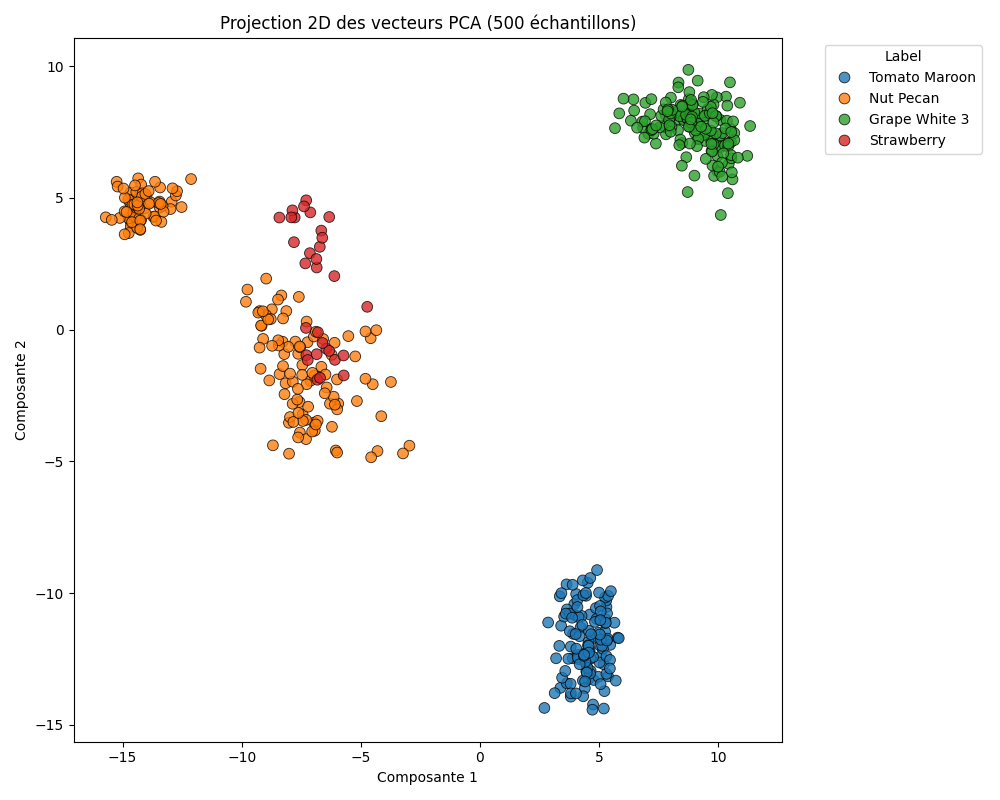

In [88]:
from IPython.display import Image, display
display(Image(filename="/tmp/pca_2d_visualisation.png"))